# new RNN

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
import random 

# Load the NetCDF file
#nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both_noncens.nc'

np.random.seed(459345)
dataset = xr.open_dataset(nc_file)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

TR=0.72

# Print dataset to inspect the contents
print(dataset)



<xarray.Dataset> Size: 813MB
Dimensions:  (subject: 60, voxel: 1989, time: 284)
Coordinates:
  * voxel    (voxel) int64 16kB 0 1 2 3 4 5 6 ... 1983 1984 1985 1986 1987 1988
  * time     (time) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * subject  (subject) <U9 2kB '118932_RL' '113619_LR' ... '148335_LR'
    task     <U5 20B ...
Data variables:
    X        (subject, voxel, time) float64 271MB ...
    Y        (subject, voxel, time) float64 271MB ...
    Y_conv   (subject, voxel, time) float64 271MB ...
Attributes:
    description:  Dataset for subject 118932, task MOTOR, acquisition RL


In [11]:
def temporal_scale(X, y, scale_range=(0.8, 1.2), ratio=0.3, keep_len=True):
    n_voxels, time_points, _ = X.shape
    
    if not keep_len:
        new_length = int(time_points * np.random.uniform(*scale_range))
        print("new_length", new_length)
        scaled_X = torch.nn.functional.interpolate(X.transpose(1,2), size=new_length).transpose(1,2)
        scaled_y = torch.nn.functional.interpolate(y.unsqueeze(1), size=new_length).squeeze(1)
    else:
        scaled_X, scaled_y = X.clone(), y.clone()
    
    for vox_idx in np.random.choice(range(n_voxels), size=int(n_voxels * ratio), replace=False):
        new_length = int(time_points * np.random.uniform(*scale_range)) if keep_len else scaled_X.shape[1]
        x_interp = torch.nn.functional.interpolate(X[vox_idx].T.unsqueeze(0), size=new_length).squeeze().T.unsqueeze(-1)
        y_interp = torch.nn.functional.interpolate(y[vox_idx].unsqueeze(0).unsqueeze(0), size=new_length).squeeze()
        
        if keep_len:
            if new_length < time_points:
                repeats = int(np.ceil(time_points / new_length))
                x_interp = x_interp.repeat(repeats, 1)[:time_points]
                y_interp = y_interp.repeat(repeats)[:time_points]
            else:
                x_interp = x_interp[:time_points]  # Only trim if longer
                y_interp = y_interp[:time_points]
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
        else:
            scaled_X[vox_idx] = x_interp
            scaled_y[vox_idx] = y_interp
            
    return scaled_X, scaled_y


def augment_data(X_train, Y_train, shift_range=(-20, +20), amplitude_range=(0.5, 1.5), noise_std=0.1, stretch_ratio=0.6):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train Tensors for the BOLD signal and predicted signals (Y).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    num_samples = X_train.shape[0]
    

    print("Plot after normalization")
    x,y = X_train[0,:],Y_train[0,:]
    plt.plot(x,label="BOLD")
    plt.plot(y,label='beta')
    plt.legend()
    plt.show()

    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)

        x,y = shifted_X,shifted_Y
        plt.plot(x,label="BOLD")
        plt.plot(y,label='beta')
        plt.legend()
        plt.show()
        

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor

        x,y = scaled_X,scaled_Y
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.legend()
        plt.show()
                
        # 4. Add Gaussian noise
        noise_X = torch.normal(mean=0, std=noise_std, size=scaled_X.shape, device=scaled_X.device)
        noisy_X = scaled_X + noise_X

        x,y = noisy_X,scaled_Y
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.legend()
        plt.show()

        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    
    return augmented_X_tensor, augmented_Y_tensor


def preprocess_subject_data(subject_data):
    """
    Preprocess the data for a given subject, including normalization, 
    handling missing values, and applying temporal shifts.

    Parameters:
    - subject_data: The data for a single subject.

    Returns:
    - X_tensor, Y_tensor: Preprocessed tensors for the BOLD signal and predicted signals.
    """
    print("Data preprocess")
    
    X_subject = subject_data['X']  # Shape: [voxels, time]
    Y_subject = subject_data['Y']  # Shape: [voxels, time]

    # Access time series for all voxels
    X_vals = X_subject.values
    Y_vals = Y_subject.values

    # Remove rows with NaNs in any voxel time series
    print("Remove rows with NaNs in any voxel time series")
    valid_mask = ~np.isnan(X_vals).any(axis=1)
    X_vals = X_vals[valid_mask]
    Y_vals = Y_vals[valid_mask]

    X_tensora = torch.tensor(X_vals- np.mean(X_vals, axis=1, keepdims=True), dtype=torch.float32)
    Y_tensora = torch.tensor(Y_vals, dtype=torch.float32)

    print("Plot before normalization")
    x,y = X_tensora[0,:],Y_tensora[0,:]
    plt.plot(x,label="BOLD")
    plt.plot(y,label='beta')
    plt.legend()
    plt.show()    
    

    # Normalize BOLD signal (X)
    print("Normalize BOLD signal (X)")
    X_vals = (X_vals - np.mean(X_vals, axis=1, keepdims=True)) / np.std(X_vals, axis=1, keepdims=True)

    # Convert to PyTorch tensors
    print("Convert to PyTorch tensors")
    X_tensor = torch.tensor(X_vals, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_vals, dtype=torch.float32)

    return X_tensor, Y_tensor


def concat_data(all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train: List of tensors, each containing training data for a subject.
    - all_X_val: List of tensors, each containing validation data for a subject.
    - all_X_test: List of tensors, each containing test data for a subject.
    - all_Y_train: List of tensors, each containing labels for a subject.
    - all_Y_val: List of tensors, each containing labels for a subject.
    - all_Y_test: List of tensors, each containing labels for a subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """

    # Concatenate lists into tensors
    X_train_def = torch.cat(all_X_train, dim=0)
    X_val_def = torch.cat(all_X_val, dim=0)
    X_test_def = torch.cat(all_X_test, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)
    Y_val_def = torch.cat(all_Y_val, dim=0).unsqueeze(-1)
    Y_test_def = torch.cat(all_Y_test, dim=0).unsqueeze(-1)

    return X_train_def, X_val_def, X_test_def, Y_train_def, Y_val_def, Y_test_def



In [9]:
def get_data_tensors(subject_ids):

    # Shuffle subject IDs
    random.seed(42)  # Set seed for reproducibility
    shuffled_subjects = subject_ids.copy()
    random.shuffle(shuffled_subjects)
    
    # Compute split indices based on percentages
    total_subjects = len(shuffled_subjects)
    train_end = int(0.6 * total_subjects)
    val_end = int(0.8 * total_subjects)
    
    # Split subjects into train, val, and test
    train_subjects = shuffled_subjects[:train_end]
    val_subjects = shuffled_subjects[train_end:val_end]
    test_subjects = shuffled_subjects[val_end:]

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []

    # Process train subjects
    for train_subj in train_subjects:
        subject_data = dataset.sel(subject=train_subj)  # Extract subject data
        X_train_tensor, Y_train_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_train_aug, Y_train_aug = augment_data(X_train_tensor, Y_train_tensor)
        # Apply temporal scaling to the augmented data
        X_train_aug, Y_train_aug = temporal_scale(X_train_aug.unsqueeze(-1), Y_train_aug)
        all_X_train.append(X_train_aug)
        all_Y_train.append(Y_train_aug)

    # Process validation subjects
    for val_subj in val_subjects:
        subject_data = dataset.sel(subject=val_subj)  # Extract subject data
        X_val_tensor, Y_val_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_val_aug, Y_val_aug = augment_data(X_val_tensor, Y_val_tensor)
        # Apply temporal scaling to the augmented data
        X_val_aug, Y_val_aug = temporal_scale(X_val_aug.unsqueeze(-1), Y_val_aug)
        all_X_val.append(X_val_aug)
        all_Y_val.append(Y_val_aug)

    # Process test subjects
    for test_subj in test_subjects:
        subject_data = dataset.sel(subject=test_subj)  # Extract subject data
        X_test_tensor, Y_test_tensor = preprocess_subject_data(subject_data)
        all_X_test.append(X_test_tensor)
        all_Y_test.append(Y_test_tensor)

    # Concatenate data for all subjects
    X_train_def, X_test_def, X_val_def, Y_train_def, Y_test_def, Y_val_def = concat_data(
        all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test)

    print(X_train_def.shape)
    print(X_val_def.shape)
    print(X_test_def.shape)
    print(Y_train_def.shape)
    print(Y_val_def.shape)
    print(Y_test_def.shape)

    return X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def


Data preprocess
Remove rows with NaNs in any voxel time series
Plot before normalization


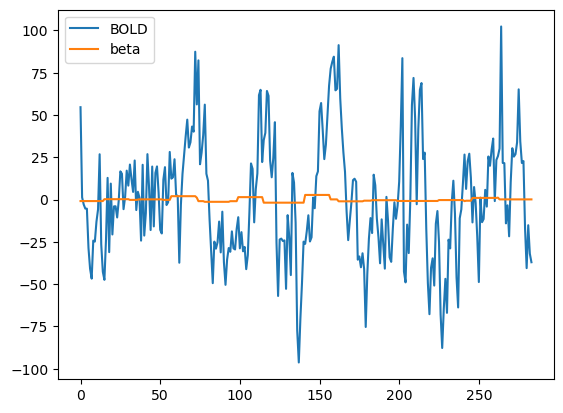

Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Plot after normalization


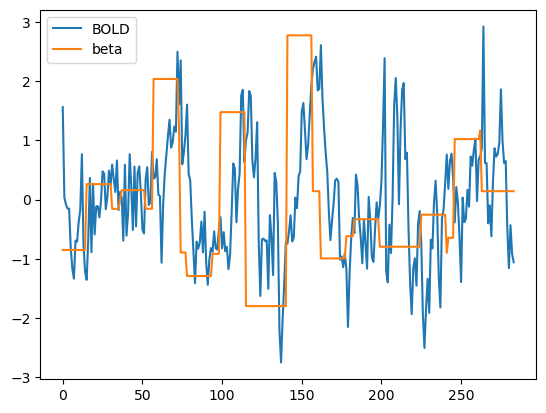

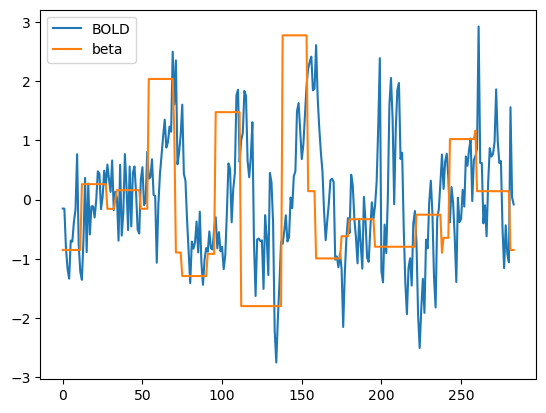

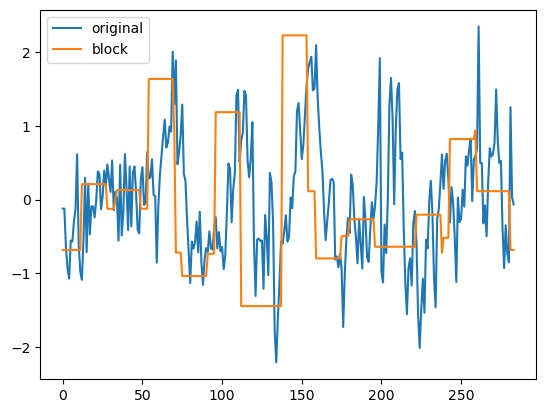

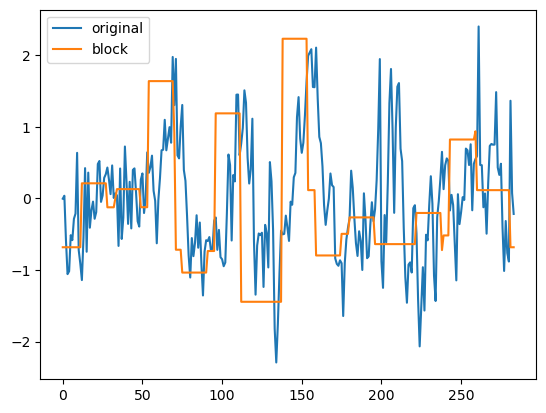

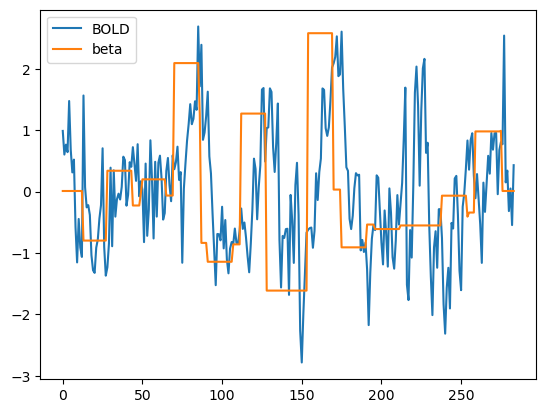

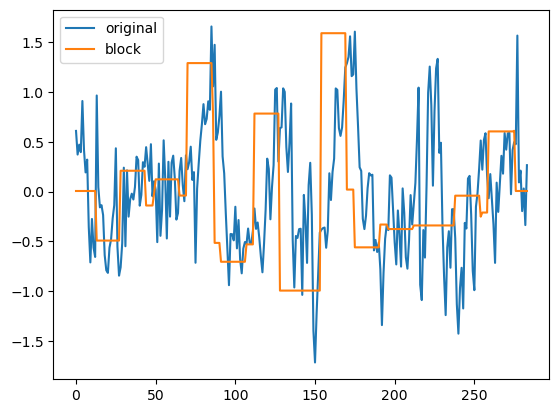

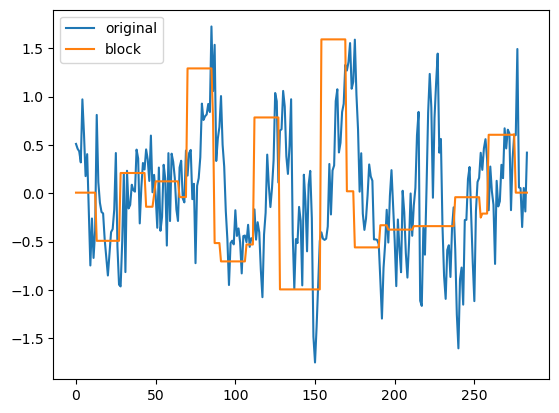

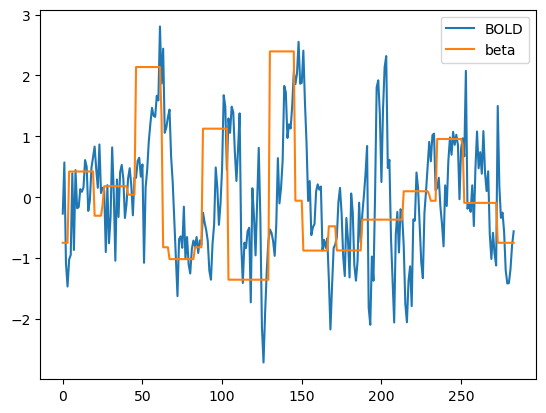

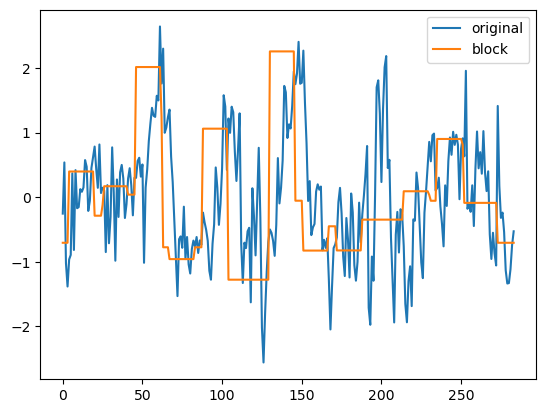

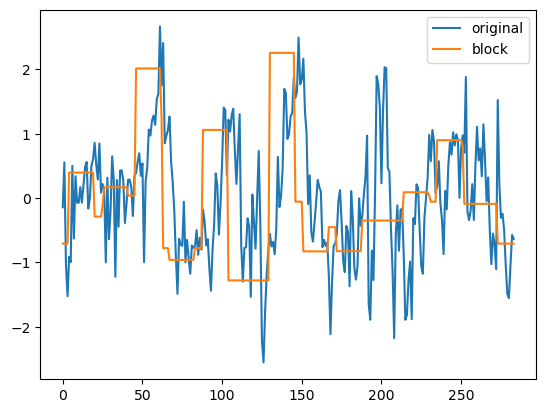

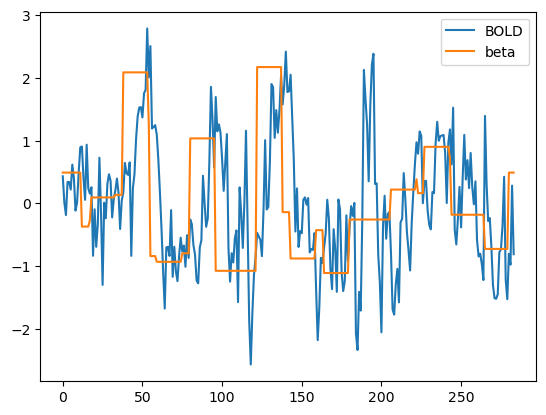

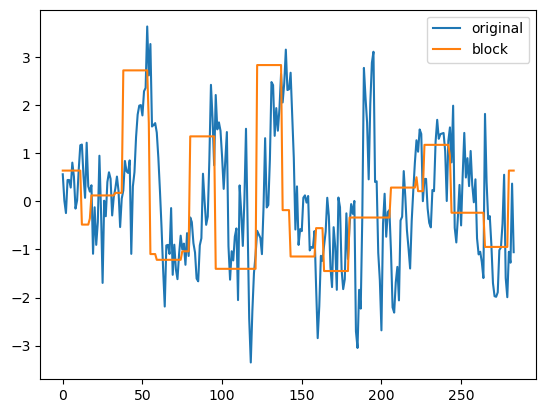

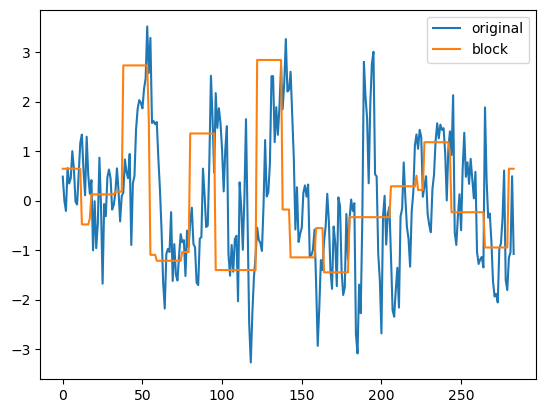

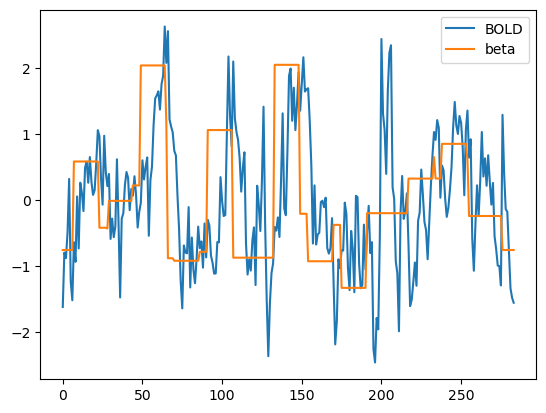

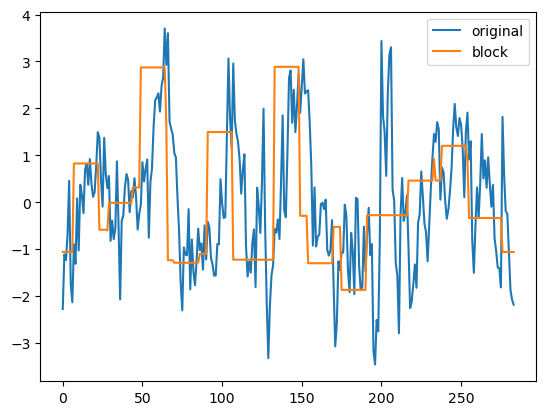

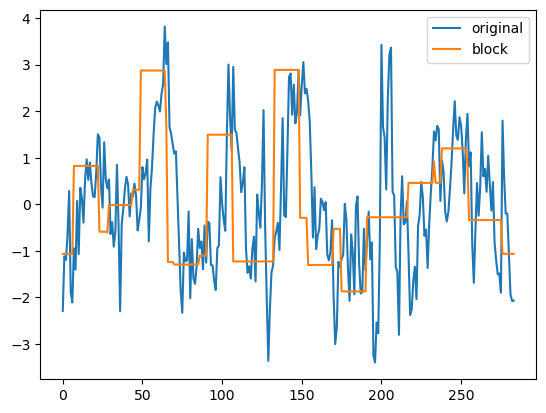

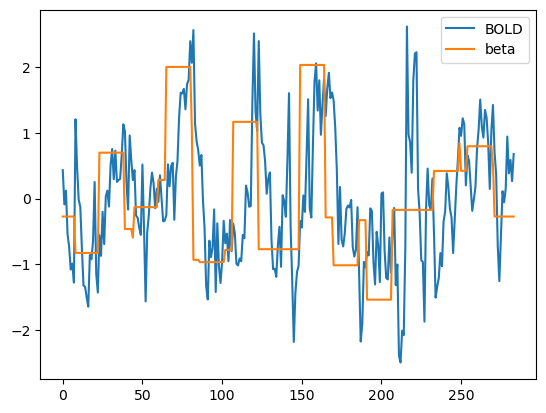

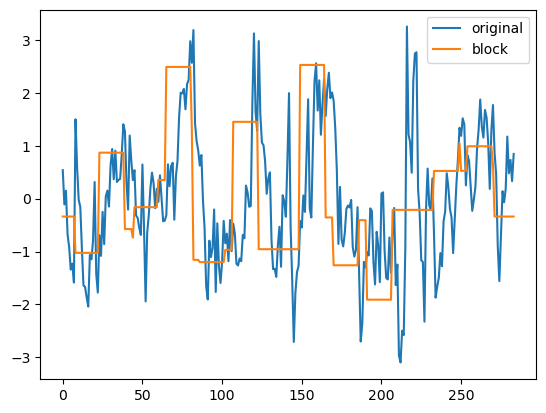

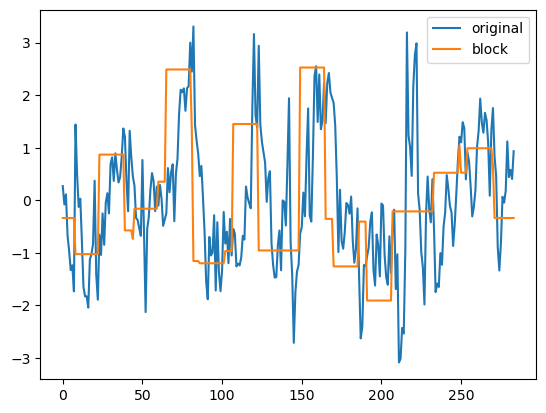

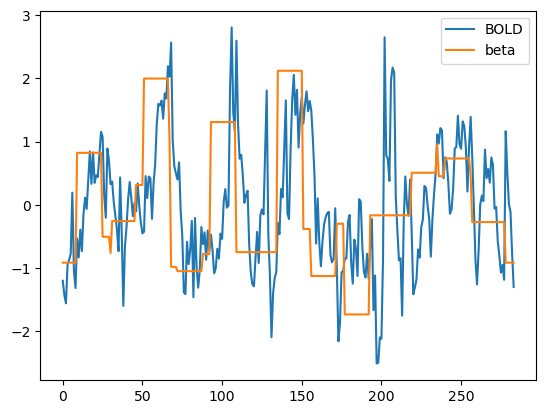

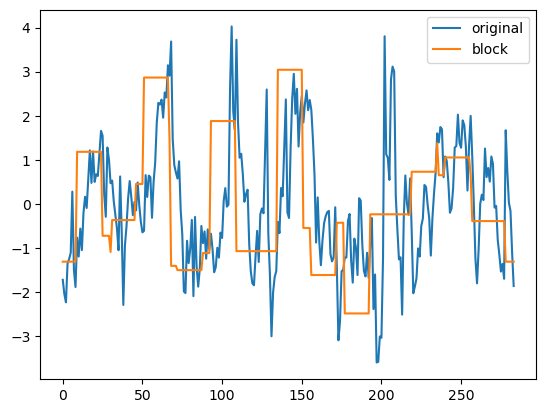

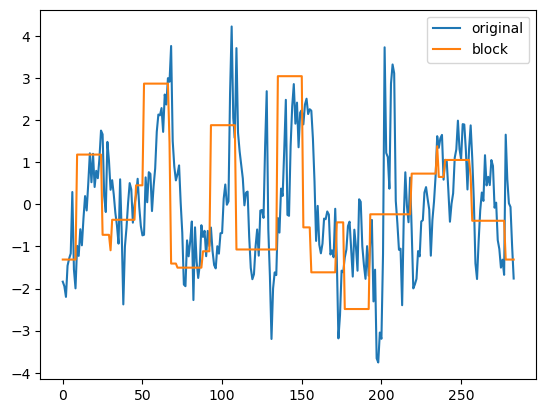

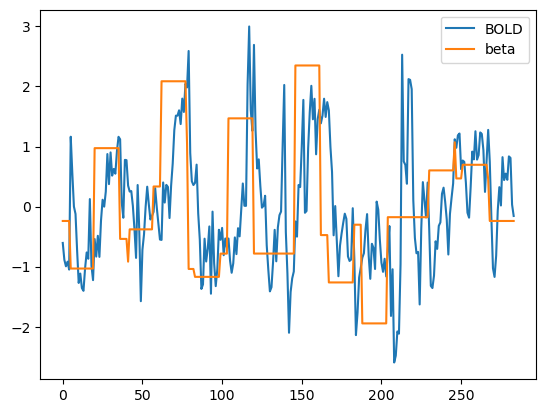

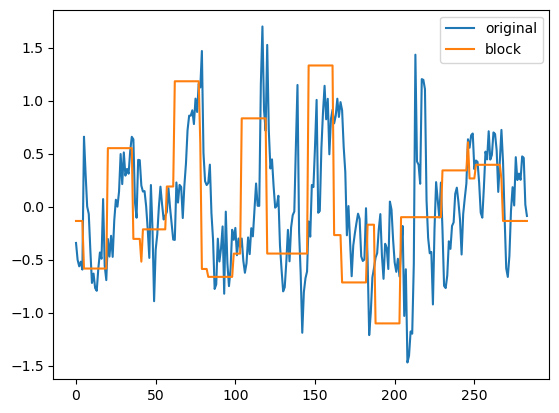

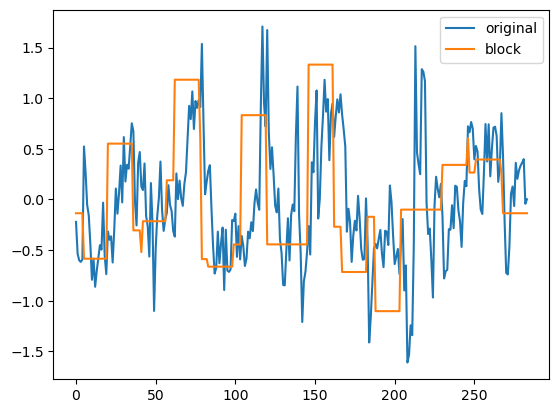

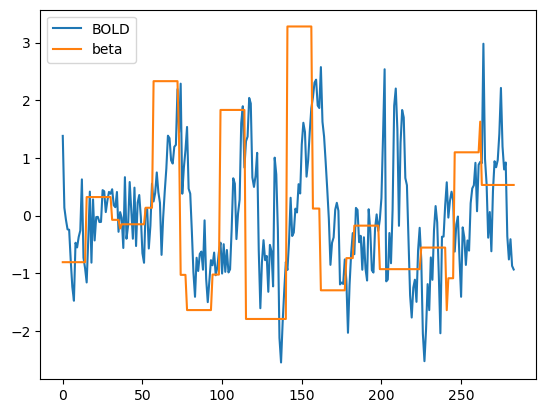

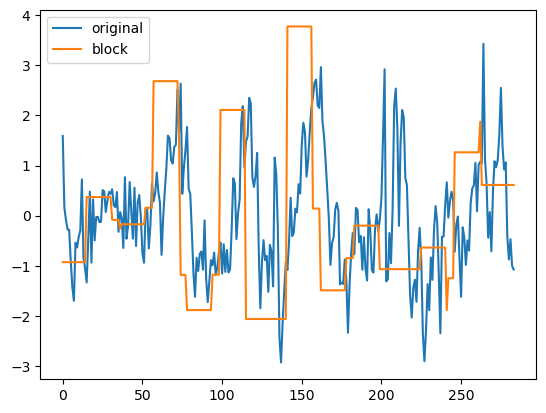

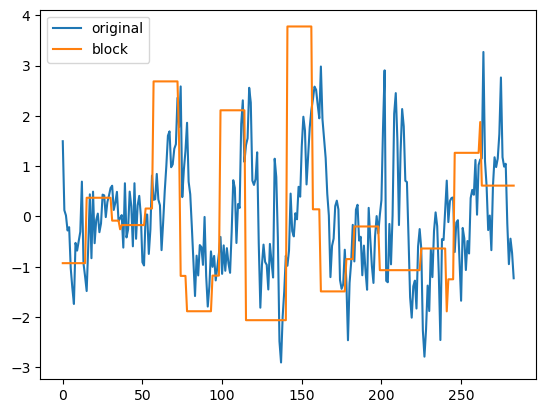

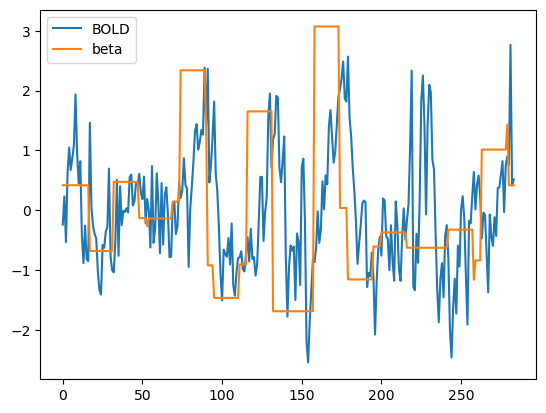

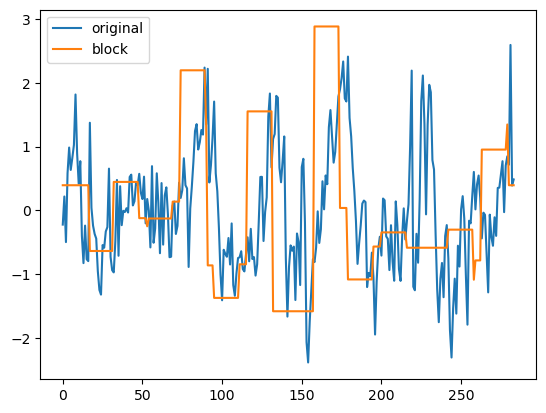

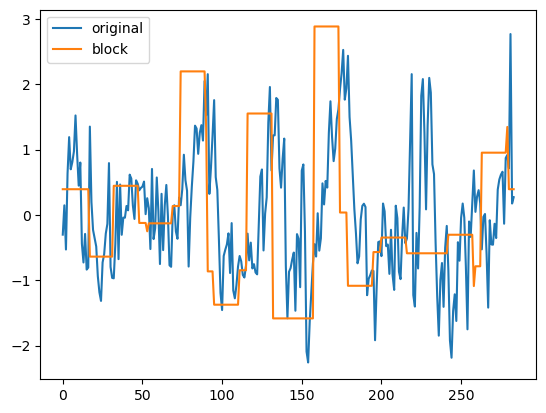

KeyboardInterrupt: 

In [12]:
subjects_ids = dataset.subject.values

X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def = get_data_tensors(subjects_ids)


In [ ]:
print(X_train_def.shape)

In [ ]:
import matplotlib.pyplot as plt
print(f"X_train_def shape: {X_train_def.shape} \nY_train_def shape: {Y_train_def.shape}")

#X_train_def = apply_lowpass_filter(X_train_def)

for i in range (5):
    x,y = X_train_def[i,:],Y_train_def[i,:]
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.legend()
    plt.show()

In [167]:
#print(torch.cuda.is_available())
#print(torch.version.cuda)
#print(torch.backends.cudnn.enabled)
#print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(2)  # Set device to cuda:2

curr_dev=torch.cuda.current_device()
#print(curr_dev)

#print(device)

#print(torch.cuda.device(curr_dev))

#print(torch.cuda.get_device_name(curr_dev))

In [178]:
# ***************************************************
#                         MODELS
# ***************************************************

import torch
import torch.nn as nn


# LSTM CLASSIC

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size):
#        super(RNNModel, self).__init__()
#        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2) # Either GRU or LSTM
#        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output
#
#    def forward(self, x):
#        # Pass through RNN
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer
#        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
#        return output
#



# CONV + LSTM

#class RNNModel(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#       super(RNNModel, self).__init__()
#        # 1D Convolutional Layer
#       self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
#       self.pool = nn.MaxPool1d(kernel_size=1)
#       
#       # RNN Layer (LSTM or GRU)
#       self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#       
#       # Fully connected layer
#       self.fc = nn.Linear(hidden_size, output_size)
#
#   def forward(self, x):
#       # Pass through CNN
#       x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
#       x = F.relu(self.conv1(x))
#       x = self.pool(x)
#       
#       # Reshape for RNN input
#       x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
#       
#       # Pass through RNN
#       rnn_out, _ = self.rnn(x)
#       
#       # Pass the RNN output (all time steps) through the FC layer
#       output = self.fc(rnn_out)  # (batch_size, seq_len, output_size)
#       return output



#FLAVIA
## LSTM + CONV 
## RNN for Kernel Prediction
#class KernelRNN(nn.Module):
#    def __init__(self, input_dim, hidden_dim, output_dim):
#        super(KernelRNN, self).__init__()
#        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#        self.fc = nn.Linear(hidden_dim, output_dim)  # Output should match the sequence length of target
#
#    def forward(self, y):
#        # y: [batch_size, time_steps, input_dim]
#        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
#        print(f"RNN output shape: {rnn_out.shape}")  # Debugging the RNN output shape
#        kernel = self.fc(rnn_out)  # Output size [batch_size, time_steps, output_dim]
#        print(f"Kernel shape after FC: {kernel.shape}")  # Debugging the kernel shape
#        return kernel  # Output shape [batch_size, time_steps, output_dim]
#
#class DeconvolutionCNN(nn.Module):
#    def __init__(self, kernel_size):
#        super(DeconvolutionCNN, self).__init__()
#        # Make sure kernel size and input channels match
#        self.conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, padding='same', bias=False)
#
#    def forward(self, y, kernel):
#        # Ensure kernel shape is [1, 1, kernel_size] for Conv1d
#        kernel = kernel.permute(0, 2, 1)  # Convert shape to [batch_size, 1, kernel_size]
#        self.conv1d.weight.data = kernel.squeeze(1)  # kernel shape: [1, kernel_size]
#
#        # Debugging: Print the shape of y before and after permuting
#        print(f"y shape before permute: {y.shape}")  # [batch_size, sequence_length, channels]
#        y = y.permute(0, 2, 1)  # From [batch_size, sequence_length, channels] to [batch_size, 1, sequence_length]
#        print(f"y shape after permute: {y.shape}")  # [batch_size, 1, sequence_length]
#
#        # Apply deconvolution (1D convolution)
#        x_hat = self.conv1d(y)  # Apply the convolution
#        print(f"x_hat shape after Conv1d: {x_hat.shape}")  # Check output shape after Conv1d
#        return x_hat
#
#
#class RNNCNNDeconvolution(nn.Module):
#    def __init__(self, input_dim, hidden_dim, kernel_size):
#        super(RNNCNNDeconvolution, self).__init__()
#        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
#        self.deconv_cnn = DeconvolutionCNN(kernel_size)
#
#    def forward(self, y):
#        kernel = self.kernel_rnn(y)
#        print(f"Kernel shape from RNN: {kernel.shape}")  # Debugging the kernel shape
#        x_hat = self.deconv_cnn(y, kernel)
#        print(f"x_hat shape after deconvolution: {x_hat.shape}")  # Debugging the output shape after deconvolution
#        return x_hat
#

# FLAVIA REVISITED

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, conv_kernel_size=3, conv_out_channels=64):
#        super(RNNModel, self).__init__()
#        
#        # LSTM layer
#        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
#        
#        # Convolutional layer after LSTM
#        self.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=conv_out_channels, kernel_size=conv_kernel_size, padding=conv_kernel_size//2)
#        
#        # Fully connected layer
#        self.fc = nn.Linear(conv_out_channels, output_size)
#
#    def forward(self, x):
#        # x: (batch_size, seq_len, input_size)
#        
#        # Pass through LSTM
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Transpose rnn_out to (batch_size, hidden_size, seq_len) for Conv1D
#        rnn_out = rnn_out.transpose(1, 2)  # Shape becomes (batch_size, hidden_size, seq_len)
#        
#        # Apply convolutional layer after LSTM
#        conv_out = self.conv1d(rnn_out)  # conv_out: (batch_size, conv_out_channels, seq_len)
#        
#        # Transpose back to (batch_size, seq_len, conv_out_channels)
#        conv_out = conv_out.transpose(1, 2)  # Shape becomes (batch_size, seq_len, conv_out_channels)
#        
#        # Apply fully connected layer
#        output = self.fc(conv_out)  # output: (batch_size, seq_len, output_size)
#        
#        return output
#
#


# Multilayer RNN (Deep RNN)

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # Stack RNN layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through stacked RNN layers
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(rnn_out)  # Use only the last time step for prediction
#        return output
#


# LSTM with Attention Mechanism

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        self.attn = nn.Linear(hidden_size, hidden_size)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through LSTM
#        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply attention mechanism at each time step
#        attn_weights = F.softmax(self.attn(lstm_out), dim=2)  # Shape: (batch_size, seq_len, hidden_size)
#        weighted_out = attn_weights * lstm_out  # Apply attention: (batch_size, seq_len, hidden_size)
#        
#        # Pass weighted outputs through fully connected layer
#        output = self.fc(weighted_out)  # Shape: (batch_size, seq_len, output_size)
#        return output
#
#

# GRU Model

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # GRU layer
#        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        # Fully connected layer
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through GRU
#        gru_out, _ = self.gru(x)  # gru_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(gru_out)  # Use only the last time step for prediction
#        return output


# Bidirectional LSTM

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(RNNModel, self).__init__()
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, _ = self.bilstm(x)  # lstm_out: (batch_size, seq_len, hidden_size * 2)
        
        # Use the output from the last time step
        output = self.fc(lstm_out)  # Last time step output
        return output





#only conv

#First Layer: Captures low-level features like edges, basic patterns, or simple variations in the data.
#Second Layer: Detects combinations of low-level features to form more abstract patterns or structures.
#Third Layer: Extracts high-level representations, such as complex temporal dependencies or global patterns across the input.

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        # First 1D Convolutional Layer
#        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
#        
#        # Second 1D Convolutional Layer
#        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
#        
#        # Third 1D Convolutional Layer
#        self.conv3 = nn.Conv1d(hidden_size, input_size, kernel_size=3, padding=1)
#        
#        # Dropout
#        self.dropout = nn.Dropout(dropout_prob)
#
#    def forward(self, x):
#        # Pass through first convolutional layer
#        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
#        x = F.relu(self.conv1(x))
#        
#        # Pass through second convolutional layer
#        x = F.relu(self.conv2(x))
#        
#        # Pass through third convolutional layer
#        x = self.dropout(x)  # Apply dropout
#        x = self.conv3(x)
#        
#        # Restore original shape (batch_size, seq_len, input_size)
#        x = x.permute(0, 2, 1)
#        return x


In [179]:

# Training and evaluation function
def train_model(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            #print(batch_x.shape) #(batch_size,timepoints,1)
            # Forward pass
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(avg_train_loss)  # Store train loss
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        total_validation_mape = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()
        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        print(f"Epoch {epoch+1}/{num_epochs}, validation Loss: {avg_validation_loss:.4f}")
    # Plot the losses after training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training and evaluation function with early stopping
def train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, num_epochs, device, patience=5
):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []   # To store average test loss for each epoch
    best_test_loss = float('inf')  # Initialize best test loss as infinity
    patience_counter = 0  # Counter to track epochs without improvement

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            predictions = model(batch_x)

            # Check shapes
            if predictions.shape != batch_y.shape:
                raise ValueError(
                    f"Shape mismatch: Predictions {predictions.shape} vs Targets {batch_y.shape}. "
                    "Ensure model output matches target dimensions."
                )

            
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()

        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        # Early stopping logic
        if avg_validation_loss < best_test_loss:
            best_test_loss = avg_validation_loss
            patience_counter = 0  # Reset patience counter
            best_model_state = model.state_dict()  # Save best model state
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
            
        scheduler.step(avg_validation_loss)  # Adjust the learning rate based on validation loss


    # Restore the best model weights
    #model.load_state_dict(best_model_state)

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_model_state



Epoch 1/100, Train Loss: 0.5044
Epoch 1/100, Validation Loss: 0.4286
Epoch 2/100, Train Loss: 0.4658
Epoch 2/100, Validation Loss: 0.4171
Epoch 3/100, Train Loss: 0.4580
Epoch 3/100, Validation Loss: 0.4164
Epoch 4/100, Train Loss: 0.4527
Epoch 4/100, Validation Loss: 0.4094
Epoch 5/100, Train Loss: 0.4485
Epoch 5/100, Validation Loss: 0.3996
Epoch 6/100, Train Loss: 0.4457
Epoch 6/100, Validation Loss: 0.3974
Epoch 7/100, Train Loss: 0.4437
Epoch 7/100, Validation Loss: 0.4036
No improvement for 1 epoch(s).
Epoch 8/100, Train Loss: 0.4416
Epoch 8/100, Validation Loss: 0.3950
Epoch 9/100, Train Loss: 0.4398
Epoch 9/100, Validation Loss: 0.3940
Epoch 10/100, Train Loss: 0.4380
Epoch 10/100, Validation Loss: 0.3946
No improvement for 1 epoch(s).
Epoch 11/100, Train Loss: 0.4363
Epoch 11/100, Validation Loss: 0.3935
Epoch 12/100, Train Loss: 0.4345
Epoch 12/100, Validation Loss: 0.3901
Epoch 13/100, Train Loss: 0.4330
Epoch 13/100, Validation Loss: 0.3905
No improvement for 1 epoch(s).
Ep

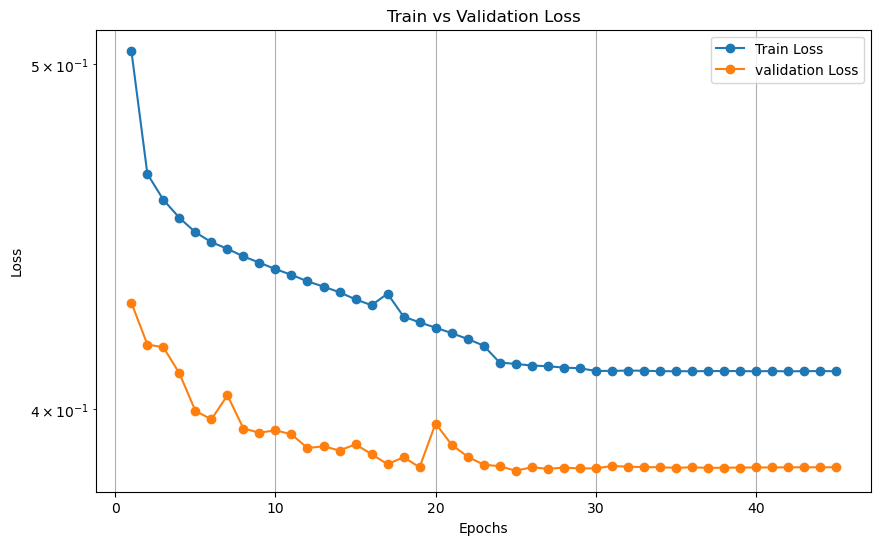

In [180]:
import torch.nn.functional as F

# Hyperparameters
input_size = 1  # input is a single feature per voxel
hidden_size = 64
output_size = 1  # we predict one value per timeseries per voxel
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
patience=20

X_train_def.to(device)
Y_train_def.to(device)
X_val_def.to(device)
Y_val_def.to(device)

train_dataset = TensorDataset(X_train_def, Y_train_def)
validation_dataset = TensorDataset(X_val_def, Y_val_def)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = RNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.L1Loss()  # MAE Loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Train the model
#train_model(model, criterion, train_loader, test_loader, optimizer, num_epochs, device)
best_model_state = train_model_with_early_stopping(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device,patience=patience)



hints by chatgpt

1. Hidden Size and Layers: 
    
    Your model uses an LSTM with hidden_size = 128 and num_layers = 2. 
    This can be appropriate, but you could experiment with different values for the number of hidden units and layers.
    
    Increase Hidden Size: If the model is underfitting, try increasing the hidden_size (e.g., try 256 or 512).
    
    Number of Layers: You could experiment with more layers (e.g., num_layers=3), but be careful, as increasing the depth can also lead to overfitting or make training more difficult.




3. Overfitting Check and Regularization
    Your model seems to be doing well in terms of loss reduction, but there’s always the potential for overfitting, especially when the validation loss starts to plateau.

    Dropout: Adding dropout layers in your LSTM can help prevent overfitting. LSTM layers don't have inherent regularization, and dropout can make the model more generalizable.

    L2 Regularization: You can add weight decay to the Adam optimizer, which is a form of L2 regularization, to penalize large weights and prevent overfitting.


3. Gradient Clipping
    Gradient Exploding: LSTMs can suffer from exploding gradients, especially with long sequences or deep networks. To prevent this, you can apply gradient clipping to the optimizer to stabilize the training.



4. Loss Function
    Mean Squared Error Loss: You're using nn.MSELoss, which is standard for regression tasks. However, if your data contains outliers, MSE can be very sensitive. If that's the case, you could try using Huber Loss, which is more robust to outliers.


5. Increase Learning Rate or Use Scheduler:

   Try a slightly higher learning rate (e.g., 0.0005) or use a learning rate scheduler like ReduceLROnPlateau.

   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [181]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

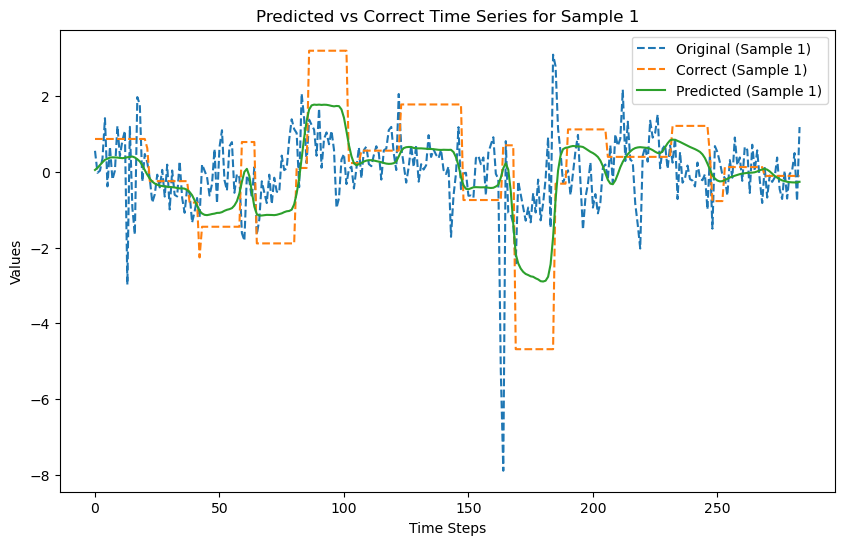

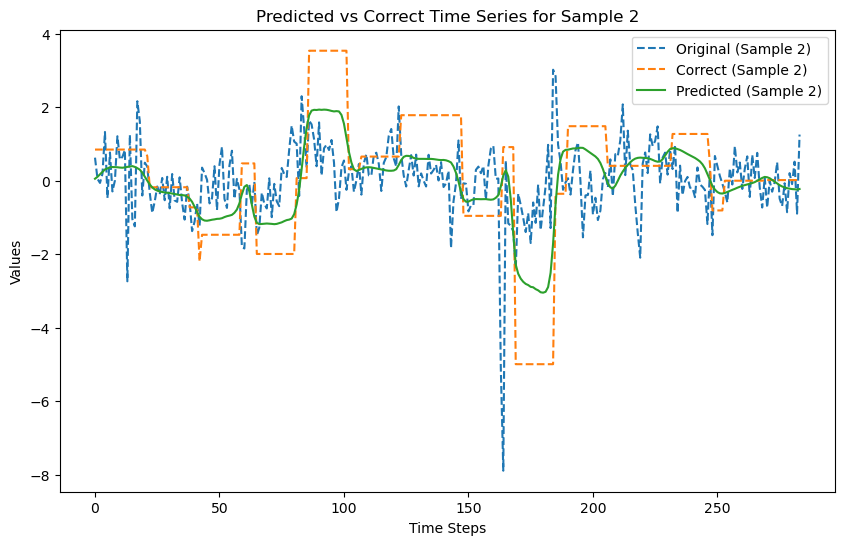

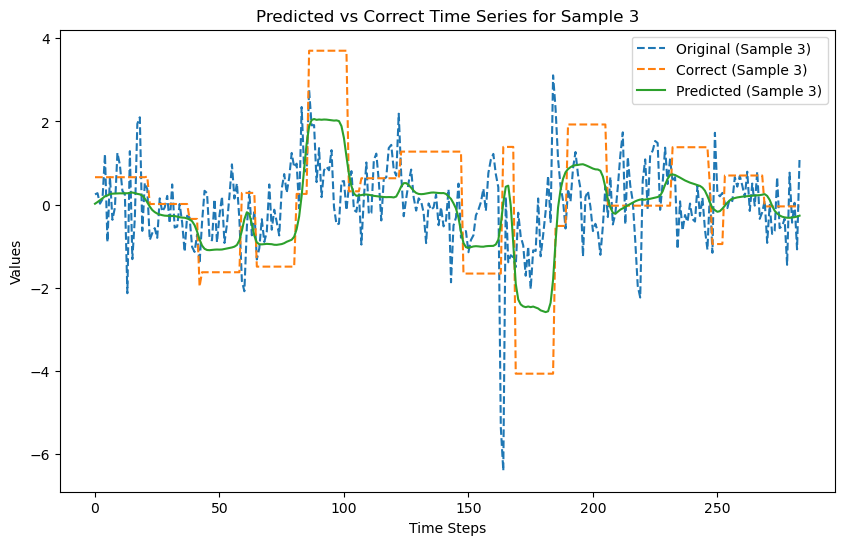

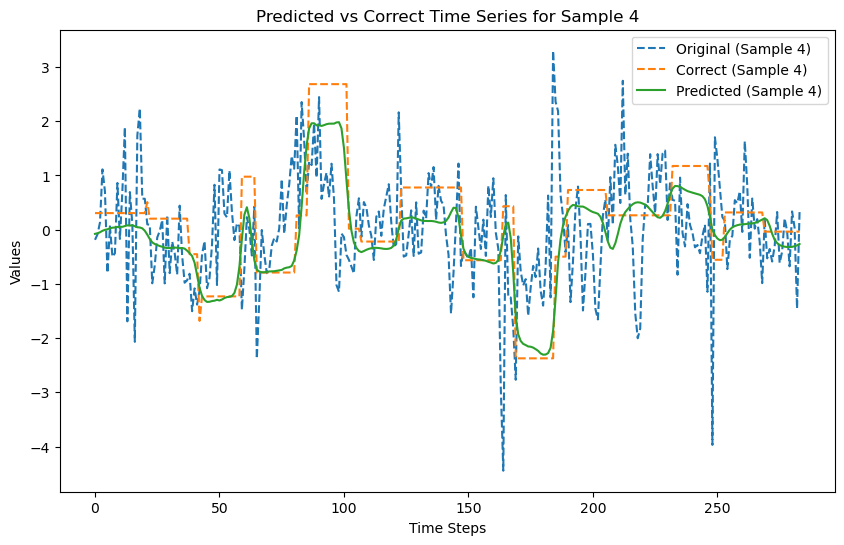

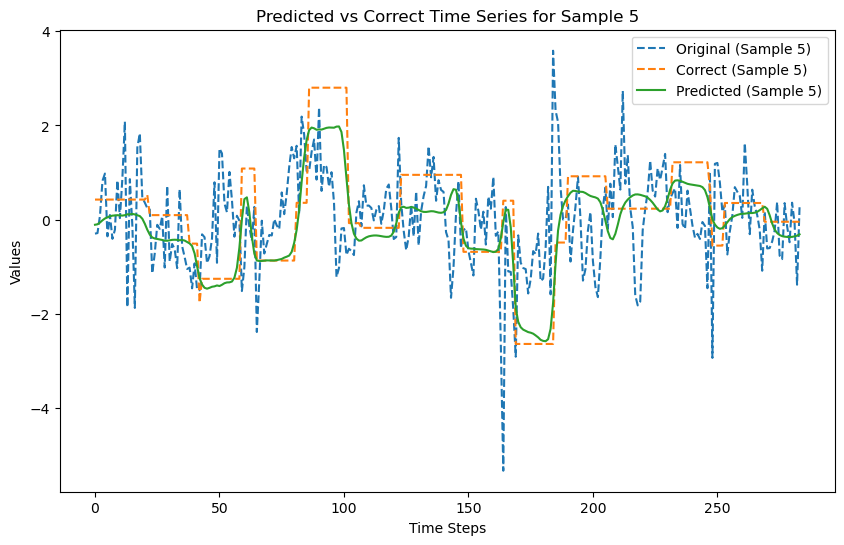

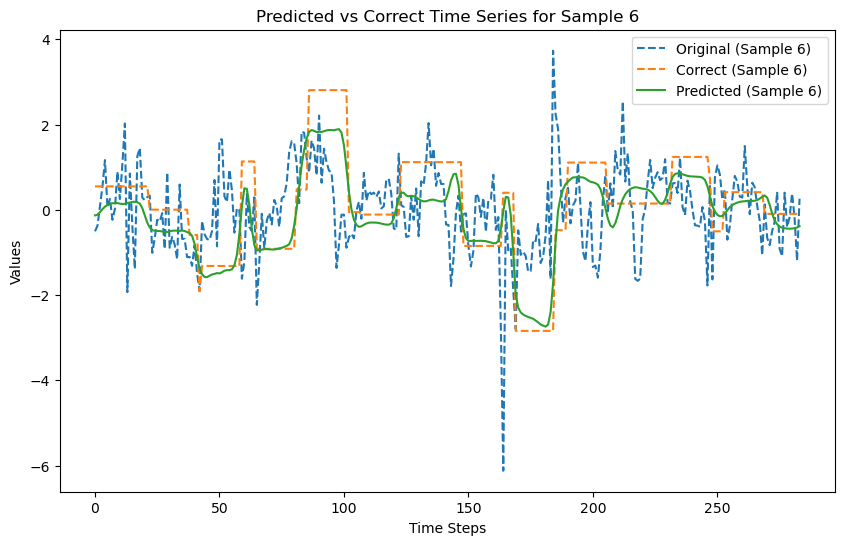

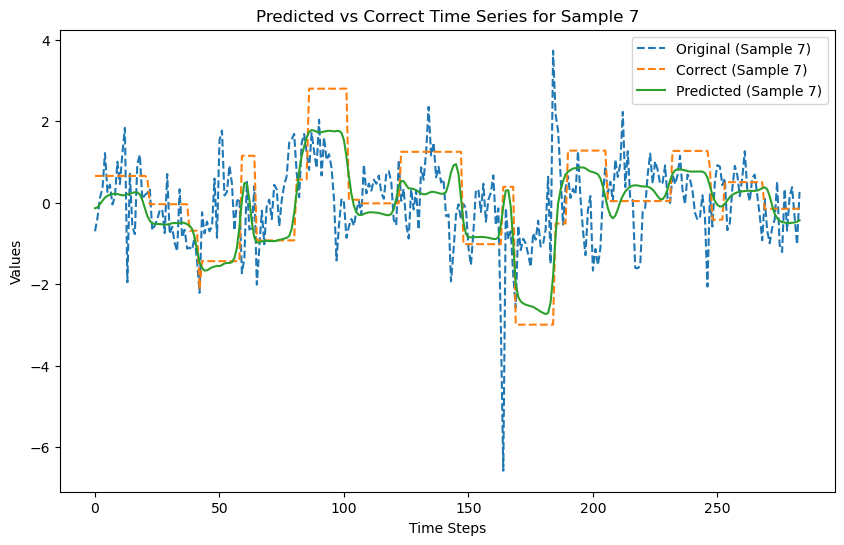

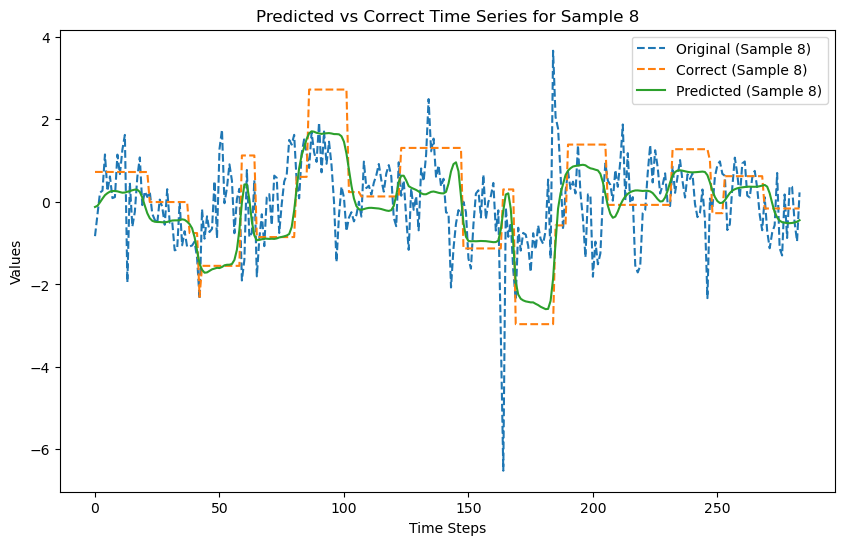

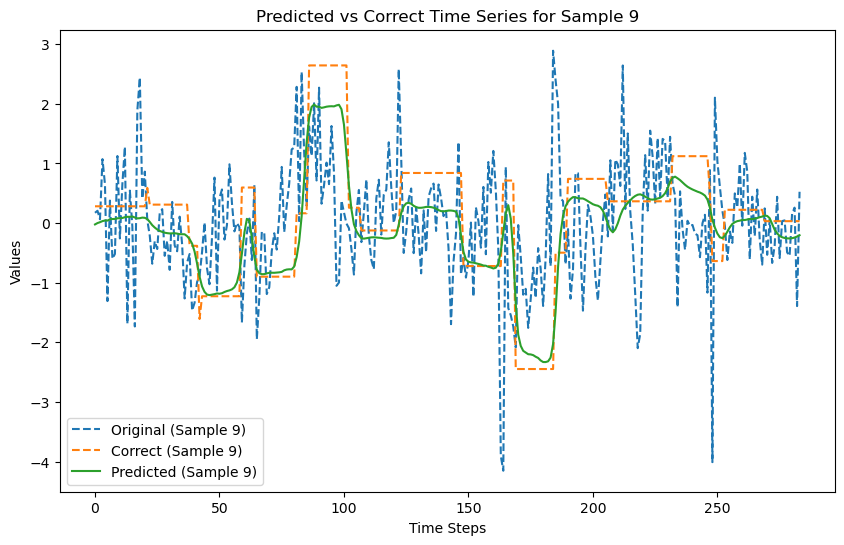

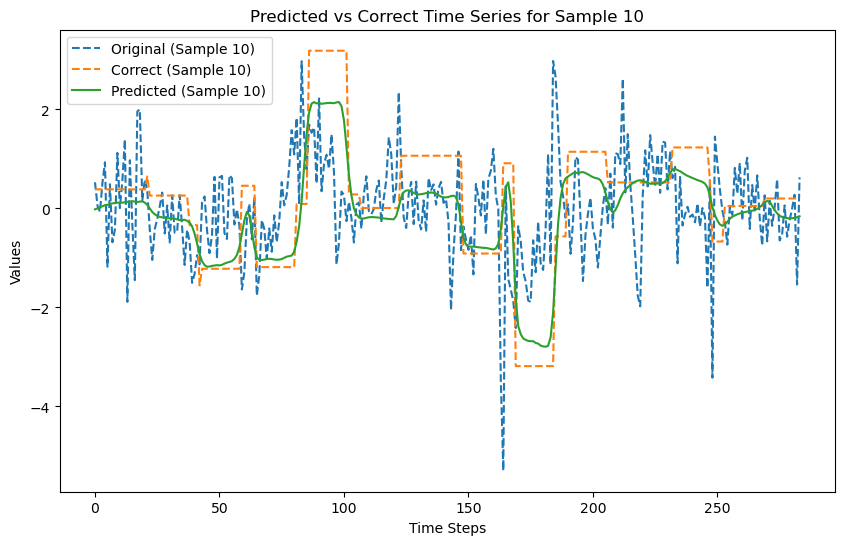

In [182]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in validation_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single= X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()

### New subjects

In [183]:
test_dataset = TensorDataset(X_test_def, Y_test_def)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

0.4605862519218902


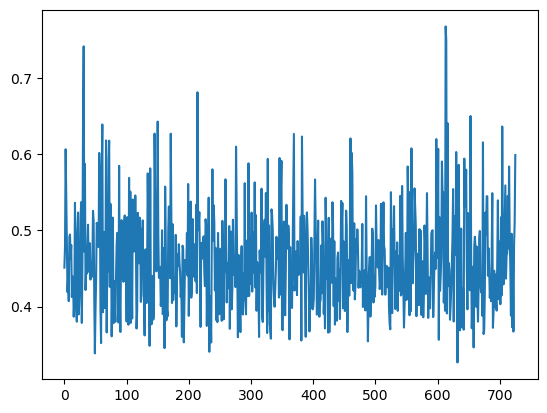

In [184]:
model.eval()
total_test_loss = 0
loss_list = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        #print(loss)
        total_test_loss += loss.item()
        loss_list.append(loss.item())

avg_test_loss = total_test_loss / len(test_loader)
print(avg_test_loss)
plt.plot(loss_list)

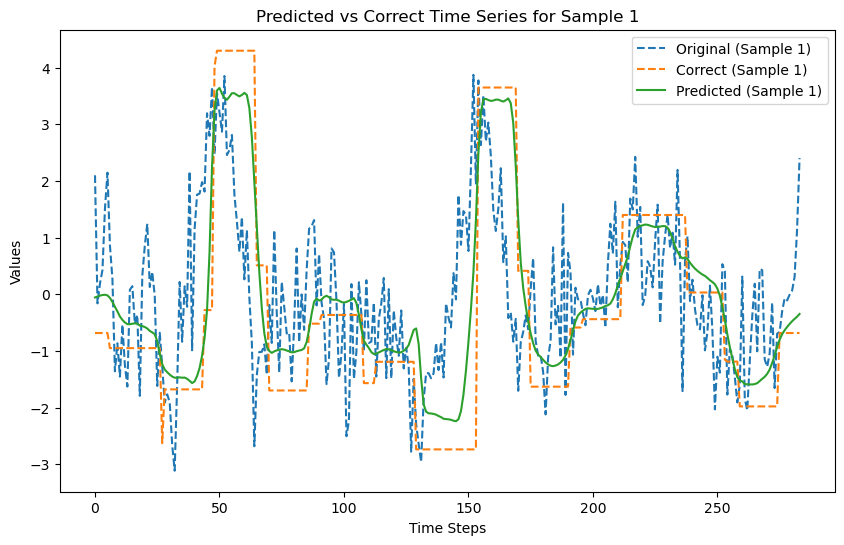

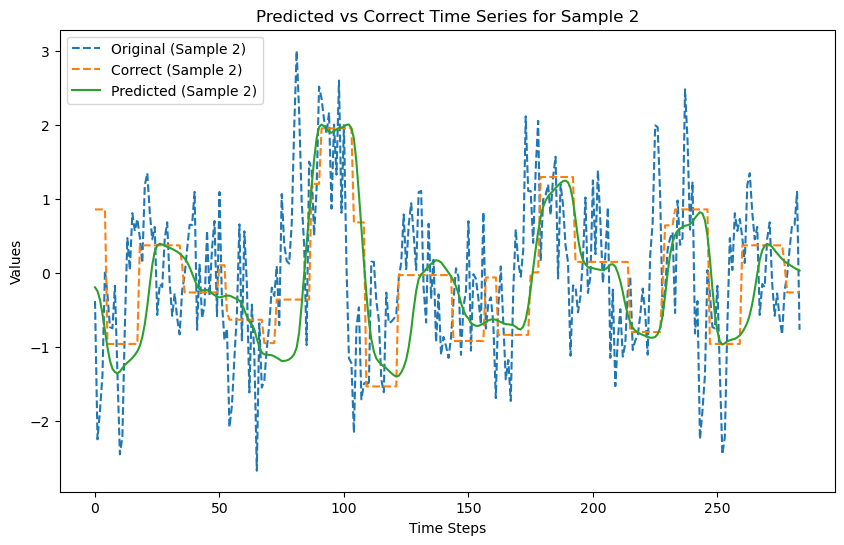

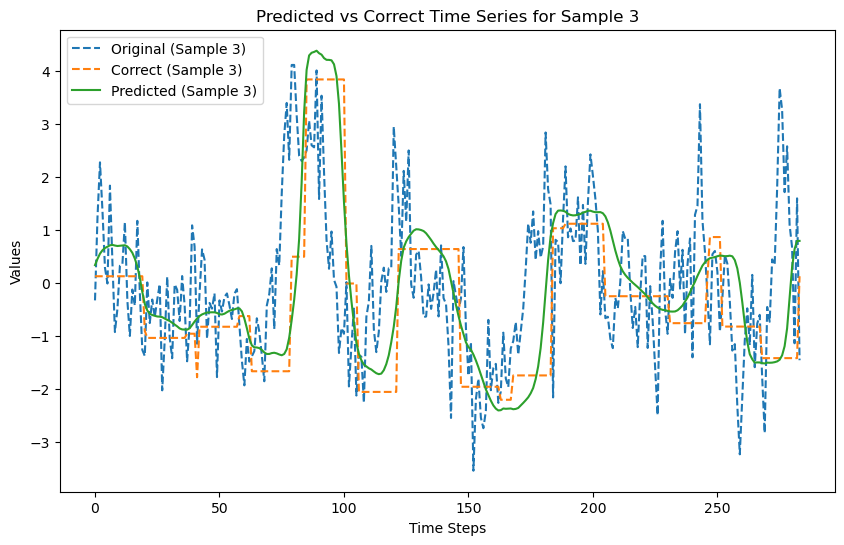

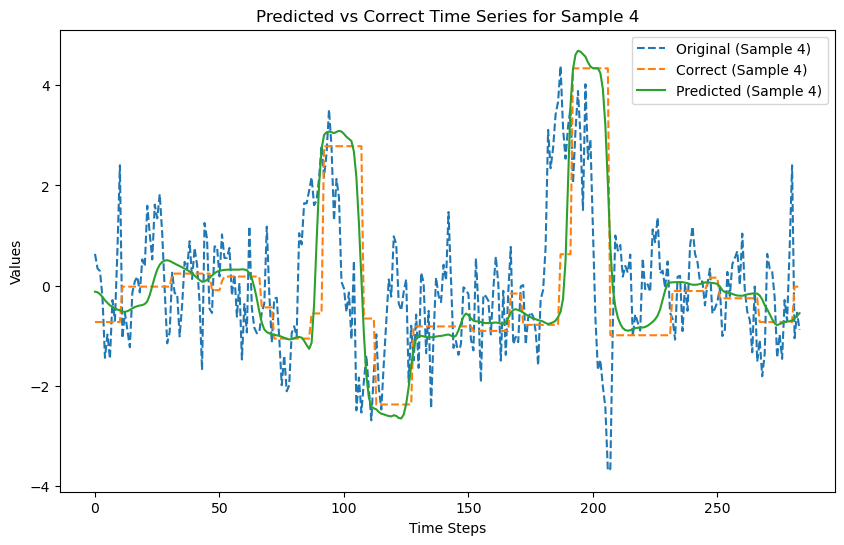

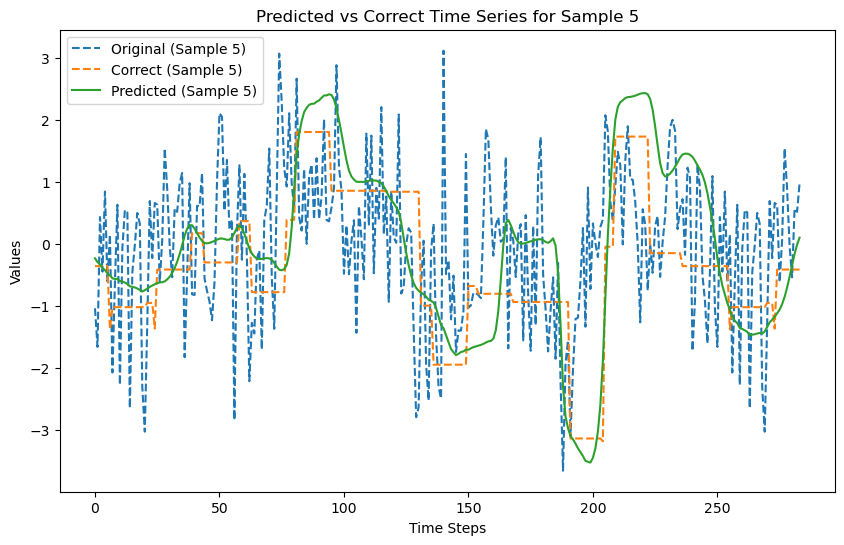

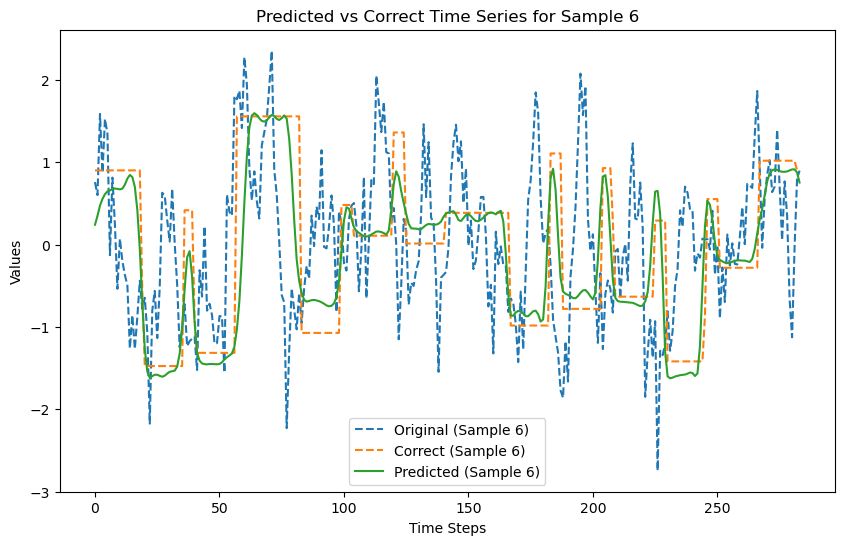

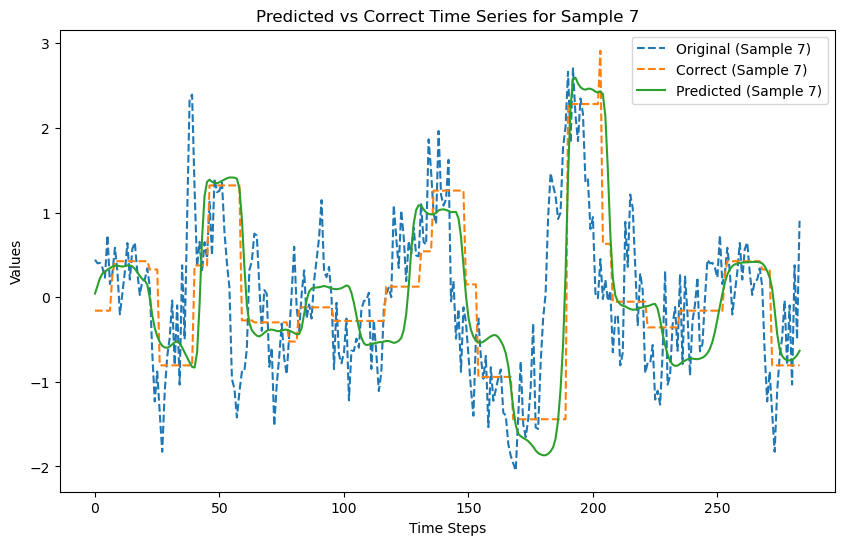

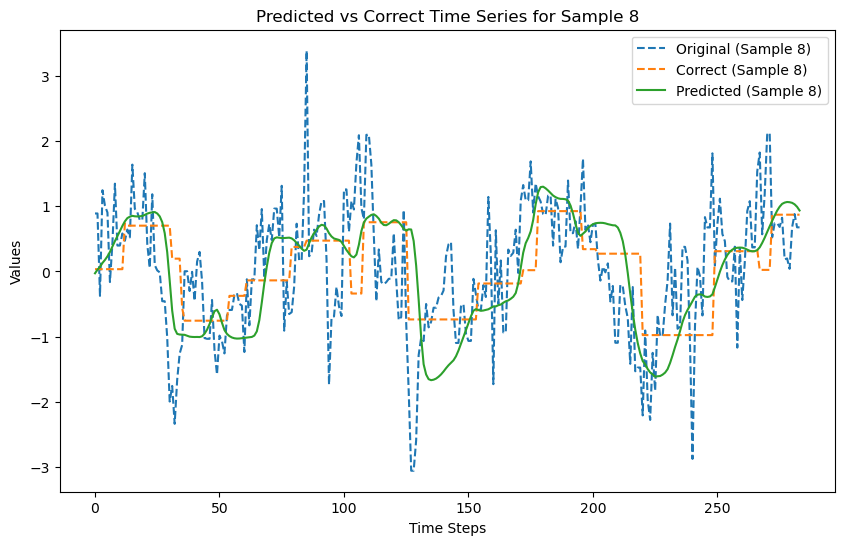

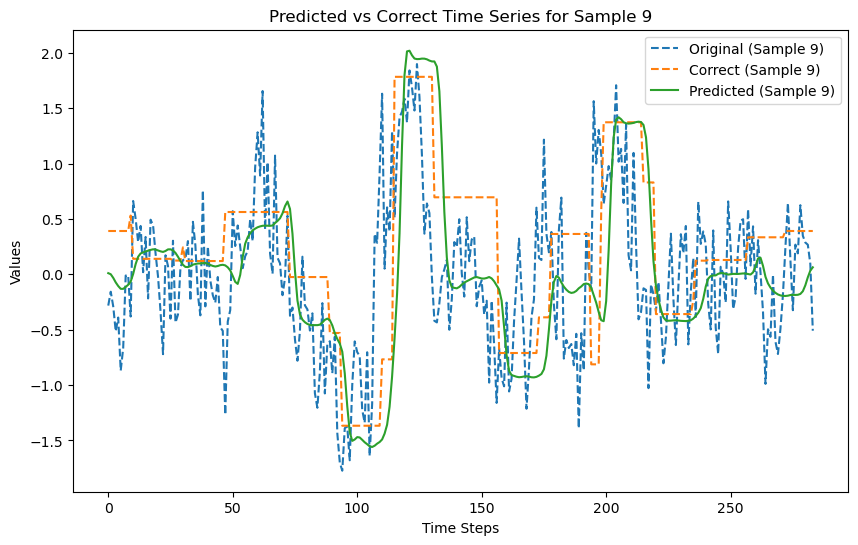

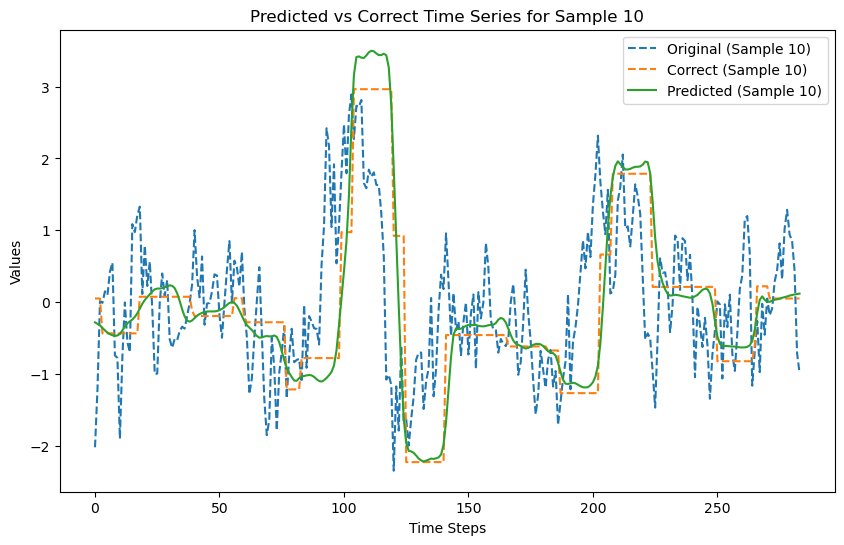

In [185]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in test_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single = X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()